In [1]:
import yaml

# Path to your YAML file
input_file_path = "outputs/2025-06-06/cedar_gemini_clean_entity_type_map.yaml"

# Load the YAML content
with open(input_file_path, "r") as file:
    loaded_data = yaml.safe_load(file)

# Now `loaded_data` is a Python dictionary
print(loaded_data.keys())  # For example, show the top-level URLs

dict_keys(['https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002', 'https://lpdaac.usgs.gov/products/mod09a1v061/', 'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en', 'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en', 'https://zenodo.org/records/8319440', 'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz', 'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e', 'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7', 'https://www.gbif.org/dataset/f9ba3c2e-0636-4f66-a4b5-b8c138046e9e', 'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5', 'https://zenodo.org/records/11440456', 'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json', 'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g', 'https://datahuiswadden.openearth.nl/

In [79]:
url_to_ds_name = {
    'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': 'Dutch forest reserves database and network (DANS)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': 'Ecotopenkaart 2016 (Datahuis Wadden)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g': 'Ecotopenkaart 2017 (Datahuis Wadden)',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/0fe7e64b-50b3-4cee-b64a-02659fc2b6c7': 'Waddenbalans 2024 (Datahuis Wadden)',
    'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en': 'Actual probability distribution for Quercus robur (EcoDataCube)',    
    'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Cloud-free reconstructed Landsat yearly blue band (EcoDataCube)',
    'https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Cloud-free reconstructed Landsat yearly green band (EcoDataCube)',
    'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en': 'Cloud-free reconstructed Landsat bimonthly NDVI (EcoDataCube)',
    'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': 'eBird observation dataset (GBIF)',
    'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': 'Waterleidingduinen camera trap P1 (GBIF)',
    'https://www.gbif.org/dataset/f9ba3c2e-0636-4f66-a4b5-b8c138046e9e': 'Waterleidingduinen camera trap P2 (GBIF)',
    'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': 'Waterleidingduinen camera trap P3 (GBIF)',
    'https://zenodo.org/records/11440456': 'Waterleidingduinen camera trap P1-3 (Zenodo)',
    'https://zenodo.org/records/8319440': 'Downscaled LUH2 land use scenarios for Belgium (Zenodo)',
    'https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002': 'Harmonized Landsat Sentinel-2 (Google Earth Engine)',
    'https://lpdaac.usgs.gov/products/mod09a1v061/': 'MODIS Terra MOD09A1 Version 6.1 (LP DAAC)',   
    }


url_to_acronym = {
    'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': 'Dutch forest database',
    'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': 'eBird',
    'https://www.gbif.org/dataset/74196cd9-7ebc-4b20-bc27-3c2d22e31ed7': 'Camera trap P1',
    'https://www.gbif.org/dataset/f9ba3c2e-0636-4f66-a4b5-b8c138046e9e': 'Camera trap P2',
    'https://www.gbif.org/dataset/bc0acb9a-131f-4085-93ae-a46e08564ac5': 'Camera trap P3',
    'https://zenodo.org/records/11440456': 'Camera trap P1-3',
    'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat blue',
    'https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json': 'Landsat green',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/api/records/A0h06_NlSEuNlium5OO3FA': 'Ecotope map 2016',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/L-mHomzGRuKAHGMkUPjY9g': 'Ecotope map 2017',
    'https://developers.google.com/earth-engine/datasets/catalog/NASA_HLS_HLSS30_v002': 'HLS',
    'https://lpdaac.usgs.gov/products/mod09a1v061/': 'MODIS',
    'https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv/collection.json?.language=en': 'Landsat NDVI',
    'https://stac.ecodatacube.eu/veg_quercus.robur_anv.eml/collection.json?.language=en': 'Oak distribution',
    'https://zenodo.org/records/8319440': 'LUH2 Belgium',
    'https://datahuiswadden.openearth.nl/geonetwork/srv/eng/catalog.search#/metadata/0fe7e64b-50b3-4cee-b64a-02659fc2b6c7': 'Wadden balance 2024',
    }

In [80]:
list(loaded_data.keys())[11]

'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json'

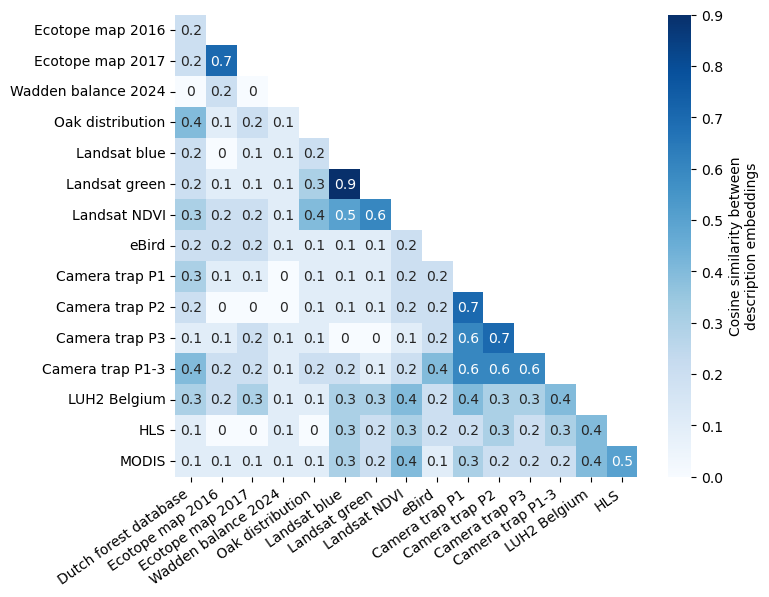

In [153]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

def plot_sim_embedding_matrix(loaded_data, ax=None, remove_upper_triangle = False, save_fig=False, 
                              concerned_attributes = ["Description"], annot_hm=True):
    embedding_list = []
    list_names =  []
    for i_attr, attr in enumerate(concerned_attributes):
        value_list = []
        # for url, metadata_dict in loaded_data.items():
        for url, _ in url_to_ds_name.items():
            metadata_dict = loaded_data[url]
            if i_attr == 0:
                list_names.append(url_to_acronym[url])
            if attr in metadata_dict:
                # Append the value of the concerned attribute to the list
                value_list.append(metadata_dict[attr][0])
            else:
                # If the attribute is not present, append a placeholder or default value
                random_text = ''.join(random.choices(string.ascii_letters + string.digits, k=8))
                value_list.append(random_text)

        # Load a pretrained model
        model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and effective

        # Encode texts to get embeddings
        embeddings = model.encode(value_list)
        embedding_list.append(embeddings)


    concatenated = np.concatenate([embedding_list[0]], axis=1)
    # Compute cosine similarity matrix
    cos_sim_matrix = cosine_similarity(concatenated)
    cos_sim_matrix = np.round(cos_sim_matrix.astype(np.float64), 1)
    cos_sim_matrix[np.where(cos_sim_matrix == 0)] = 0  # get rid of -0.0 rounding issues

    concerned_attributes_string = "&".join(concerned_attributes)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    if remove_upper_triangle:
        # Set upper triangle to NaN
        mask = np.triu(np.ones_like(cos_sim_matrix, dtype=bool), k=0)
        cos_sim_matrix[mask] = np.nan
        sns.heatmap(cos_sim_matrix[1:, :-1], annot=True, xticklabels=range(len(value_list) - 1), yticklabels=range(len(value_list) - 1), 
                    ax=ax, cmap=sns.color_palette("Blues", as_cmap=True), square=True, rasterized=True,
                    cbar_kws={'label': 'Cosine similarity between\ndescription embeddings'})
        ax.set_xticklabels(list_names[:-1], rotation=35, ha='right')
        ax.set_yticklabels(list_names[1:], rotation=0, ha='right')
    else:
        sns.heatmap(cos_sim_matrix, annot=annot_hm, xticklabels=range(len(value_list)), yticklabels=range(len(value_list)), 
                    ax=ax, cmap=sns.color_palette("Blues", as_cmap=True), square=True, rasterized=True,
                    cbar_kws={'label': 'Cosine similarity between\ndescription embeddings'})
        ax.set_xticklabels(list_names, rotation=35, ha='right')
        ax.set_yticklabels(list_names, rotation=0, ha='right')
    # ax.set_title("Cosine Similarity Between Datasets:" + " " + concerned_attributes_string)

    if save_fig:
        fig.savefig(f"figs/cosine_similarity_{concerned_attributes_string}.pdf", bbox_inches='tight')

plot_sim_embedding_matrix(loaded_data, remove_upper_triangle=True, save_fig=False)

Dataset 15:
  - Ecotopenkaart Waddenzee volgens de ZES.1 Typologie

Dataset 12:
  - Een ecotoop is een ecomorfologische, landschappelijke karteerbare eenheid..

----------------------
Dataset 3:
  - NDVI. NDVI quantifies vegetation greenness, computed from 30-m bi-monthly aggregated
    and gapfilled GLAD Landsat ARD from 2000 to 2022.

Dataset 14:
  - Blue band aggregated yearly from 30-m bi-monthly gapfilled GLAD Landsat ARD blue
    band from 2000 to 2022.

------------------
Dataset 11:
  - Blue band aggregated yearly from 30-m bi-monthly gapfilled GLAD Landsat ARD blue
    band from 2000 to 2022.

Dataset 14:
  - Blue band aggregated yearly from 30-m bi-monthly gapfilled GLAD Landsat ARD blue
    band from 2000 to 2022.

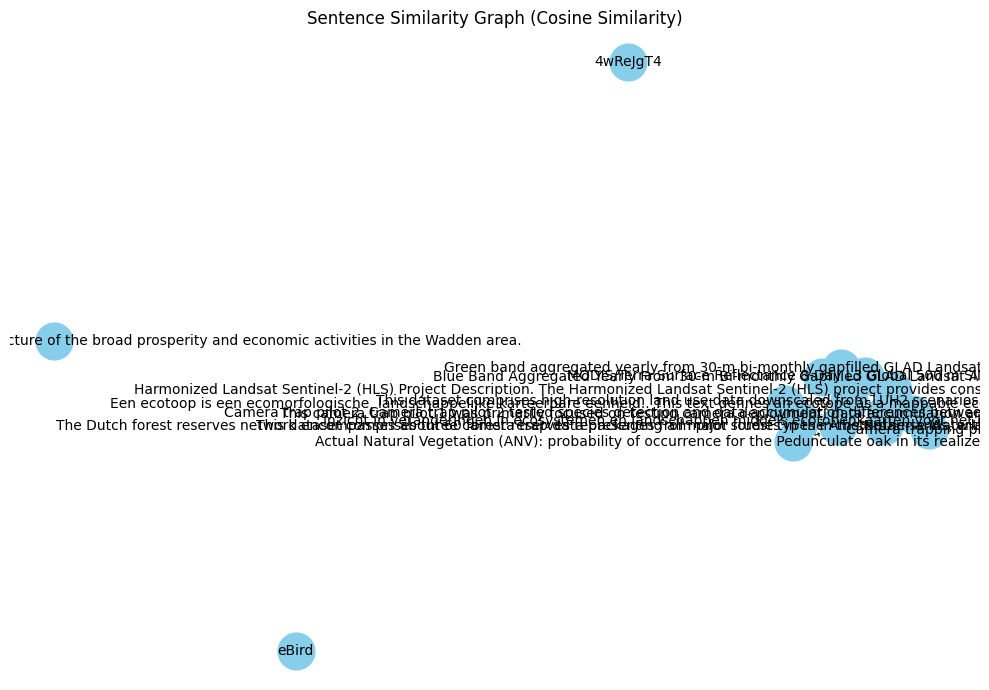

In [69]:
import networkx as nx

texts = value_list  # Use the list of values as texts for the graph

# Create graph
G = nx.Graph()

# Add nodes
for i, text in enumerate(texts):
    G.add_node(i, label=text)

# Add edges with weights (only if similarity > threshold to reduce clutter)
threshold = 0.3
for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        weight = cos_sim_matrix[i, j]
        if weight > threshold:
            G.add_edge(i, j, weight=weight)

# Compute layout — higher weights = stronger spring pull
# Invert similarity to distance: higher similarity = shorter distance
distances = {(i, j): 1 / cos_sim_matrix[i, j] for i, j in G.edges}
pos = nx.spring_layout(G, weight=None, k=None, scale=2, iterations=100, pos=None, fixed=None, center=None, dim=2)

# Draw nodes and edges
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*4 for u, v in G.edges], alpha=0.6)
nx.draw_networkx_labels(G, pos, labels={i: texts[i] for i in G.nodes}, font_size=10)

# Draw edge labels (similarity values)
edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Sentence Similarity Graph (Cosine Similarity)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [1]:
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import numpy as np
import umap
# Dimensionality reduction to 2D
reduced = TSNE(n_components=2, metric='cosine', perplexity=5, random_state=42).fit_transform(embeddings)

# reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
# reduced = reducer.fit_transform(embeddings)

# Create scatter plot
fig = go.Figure()

# Add nodes
for i, (x, y) in enumerate(reduced):
    fig.add_trace(go.Scatter(
        x=[x], y=[y],
        mode='markers+text',
        text=[str(i)],
        textposition="top center",
        marker=dict(size=10),
        hoverinfo='text'
    ))

# Optionally: Add lines for high-similarity pairs
threshold = 0.5
for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        if cos_sim_matrix[i][j] > threshold:
            fig.add_trace(go.Scatter(
                x=[reduced[i][0], reduced[j][0]],
                y=[reduced[i][1], reduced[j][1]],
                mode='lines',
                line=dict(width=cos_sim_matrix[i][j]*5, color='lightgray'),
                hoverinfo='skip'
            ))

fig.update_layout(
    title="Interactive 2D Sentence Similarity Graph (TSNE)",
    showlegend=False,
    margin=dict(l=20, r=20, t=40, b=20),
    xaxis=dict(scaleanchor='y', scaleratio=1),
    yaxis=dict(scaleanchor='x', scaleratio=1),
)
fig.show()


NameError: name 'embeddings' is not defined

# Run with Temporal coverage

In [84]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

concerned_attributes = ["Temporal coverage"]
embedding_list = []
list_names = []
for i_atrr, attr in enumerate(concerned_attributes):
    value_list = []
    for url, metadata_dict in loaded_data.items():
        if i_atrr == 0:
            list_names.append(url_to_acronym[url])
        if attr in metadata_dict:
            if metadata_dict[attr][0] != "N/A":
                # Append the value of the concerned attribute to the list
                value_list.append(metadata_dict[attr][0])
        
value_list

['2015-11-28T00:00:00Z–2025-05-31T23:38:19Z',
 '2000-02-18 to Present',
 '2000-01-01 00:00:00 UTC – 2020-12-31 00:00:00 UTC',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC',
 'Present to 2050',
 '1982-2005 (Measurements), 1983-2000 (Designation)',
 'January 1, 1800 - December 31, 2023',
 'August 13th 2021 - August 2023',
 'August 14, 2021 - September 24, 2021',
 'March 1, 2023 - March 31, 2023',
 '2021–2023',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC',
 '2017',
 '2024',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC',
 '2010-12-08 to 2016-11-01']

In [38]:
from google import genai
import os
from dotenv import load_dotenv

# Load environment variables from .env file
# load_dotenv()
load_dotenv(dotenv_path='keys.env')

client = genai.Client(
    api_key=os.getenv("GEMINI_API_KEY")
)
value_list_string = "<END>\n".join(value_list)

llm_model = "gemini-2.5-flash-preview-05-20"

prompt = f"""
You are an expert in data formatting. Given a list of time points or time period ranges separted by <END>, your task is to normalize and format them into a consistent list of strings separated by commas.

Formatting rules:

    If an item is a single year (e.g., 2000), convert it into a full date range: 2000-01-01-2000-12-31.

    If a date-time includes hours, minutes, or seconds (e.g., 2000-01-01 00:00:00 UTC), remove the time portion and keep only the date in YYYY-MM-DD format.

    If Present is included, keep it as is.

    Otherwise express time periods as YYYY-MM-DD-YYYY-MM-DD.

    Separate all formatted periods with commas in the output.

    Do not include any additional text, code or formatting in the output, just the formatted string.

    If multiple periods are given, merge them into a single string with the format YYYY-MM-DD-YYYY-MM-DD, from the earliest to the latest date.

Input list:
{value_list_string}

Output:
"""

response = client.models.generate_content(
    model=llm_model,
    contents=prompt,
)
response_text = response.text

In [20]:
value_list_string.split('\n')

['2015-11-28T00:00:00Z–2025-05-31T23:38:19Z<END>',
 '2000-02-18 to Present<END>',
 '2000-01-01 00:00:00 UTC – 2020-12-31 00:00:00 UTC<END>',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC<END>',
 'Present to 2050<END>',
 '1982-2005 (Measurements), 1983-2000 (Designation)<END>',
 'January 1, 1800 - December 31, 2023<END>',
 'August 13th 2021 - August 2023<END>',
 'August 14, 2021 - September 24, 2021<END>',
 'March 1, 2023 - March 31, 2023<END>',
 '2021–2023<END>',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC<END>',
 '2017<END>',
 '2024<END>',
 '2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC<END>',
 '2010-12-08 to 2016-11-01']

In [39]:
response_text 

'2015-11-28-2025-05-31,2000-02-18-Present,2000-01-01-2020-12-31,2000-01-01-2022-12-31,Present-2050-12-31,1982-01-01-2005-12-31,1800-01-01-2023-12-31,2021-08-13-2023-08-31,2021-08-14-2021-09-24,2023-03-01-2023-03-31,2021-01-01-2023-12-31,2000-01-01-2022-12-31,2017-01-01-2017-12-31,2024-01-01-2024-12-31,2000-01-01-2022-12-31,2010-12-08-2016-11-01'

In [110]:
assert len(response_text.split(',')) == len(value_list), f'Number of inputs ({len(value_list)}) does not match number of outputs ({len(response_text.split(","))})'
import pandas as pd
list_names_sorted = [url_to_acronym[url] for url in url_to_ds_name.keys()]

save_table = True
df_conversion = pd.DataFrame({
    "Dataset": list_names,
    "LLM-retrieved temporal coverage": [x.rstrip('<END>') for x in value_list_string.split('\n')],
    "LLM-formatted temporal coverage": response_text.split(',')

})
df_conversion = df_conversion.set_index('Dataset').reindex(list_names_sorted).reset_index()
cols_save = ['Dataset', 'LLM-retrieved temporal coverage', 'LLM-formatted temporal coverage']
date_present = '2025-06-07'
for ii, val in enumerate(df_conversion['LLM-formatted temporal coverage']):
    if 'Present' in val:
        ## replace 'Present' with the current date
        df_conversion.loc[ii, 'LLM-formatted temporal coverage'] = val.replace('Present', date_present)

df_conversion['start_date'] = df_conversion['LLM-formatted temporal coverage'].apply(lambda x: '-'.join(x.split('-')[:3]))
df_conversion['end_date'] = df_conversion['LLM-formatted temporal coverage'].apply(lambda x: '-'.join(x.split('-')[3:]))
## convert 'YYYY-MM-DD' to datetime
df_conversion['start_date'] = pd.to_datetime(df_conversion['start_date'], format='%Y-%m-%d')
df_conversion['end_date'] = pd.to_datetime(df_conversion['end_date'], format='%Y-%m-%d')
if save_table:
    ## to tex
    df_conversion[cols_save].to_latex("figs/temporal_coverage_conversion.tex", index=False, escape=False, 
                           caption="After the LLM metadata harvester retrieved the temporal coverage of each dataset, another LLM call was made to convert them into a consistent format (YYYY-MM-DD-YYYY-MM-DD).",
                           label="tab:temporal_coverage_conversion")
    
df_conversion



,Dataset,LLM-retrieved temporal coverage,LLM-formatted temporal coverage,start_date,end_date
0,Dutch forest database,"1982-2005 (Measurements), 1983-2000 (Designation)",1982-01-01-2005-12-31,1982-01-01,2005-12-31
1,Ecotope map 2016,2010-12-08 to 2016-11-01,2010-12-08-2016-11-01,2010-12-08,2016-11-01
2,Ecotope map 2017,2017,2017-01-01-2017-12-31,2017-01-01,2017-12-31
3,Wadden balance 2024,2024,2024-01-01-2024-12-31,2024-01-01,2024-12-31
4,Oak distribution,2000-01-01 00:00:00 UTC – 2020-12-31 00:00:00 UTC,2000-01-01-2020-12-31,2000-01-01,2020-12-31
5,Landsat blue,2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC,2000-01-01-2022-12-31,2000-01-01,2022-12-31
6,Landsat green,2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC,2000-01-01-2022-12-31,2000-01-01,2022-12-31
7,Landsat NDVI,2000-01-01 00:00:00 UTC – 2022-12-31 00:00:00 UTC,2000-01-01-2022-12-31,2000-01-01,2022-12-31
8,eBird,"January 1, 1800 - December 31, 2023",1800-01-01-2023-12-31,1800-01-01,2023-12-31
9,Camera trap P1,August 13th 2021 - August 2023,2021-08-13-2023-08-31,2021-08-13,2023-08-31


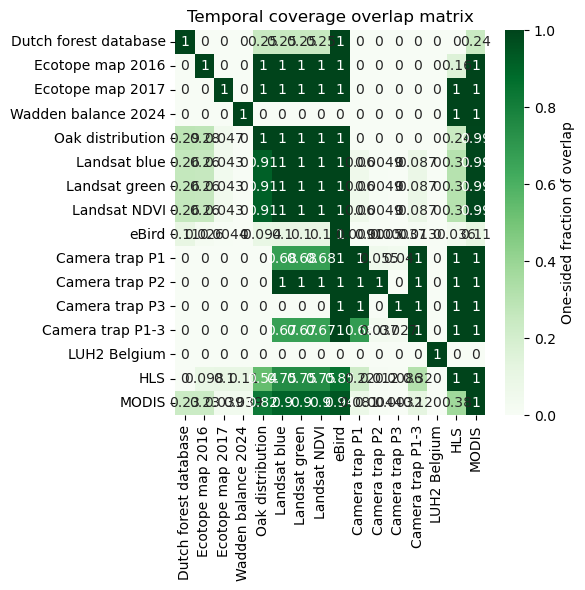

In [150]:
def plot_temp_overlap(df_conversion, save_fig=False, ax=None, overlap_method='one-sided', annot_hm=True):
        
    overlap_matrix = np.zeros((len(df_conversion), len(df_conversion)))
    for i in range(len(df_conversion)):
        for j in range(len(df_conversion)):
            # if i != j:
            start_i = df_conversion['start_date'].iloc[i]
            end_i = df_conversion['end_date'].iloc[i]
            start_j = df_conversion['start_date'].iloc[j]
            end_j = df_conversion['end_date'].iloc[j]
            
            # Check for overlap
            if start_i <= end_j and start_j <= end_i:
                overlap_matrix[i, j] = 1  # Overlap exists
                if overlap_method == 'two-sided':
                    frac_overlap = (min(end_i, end_j) - max(start_i, start_j)).days / (max(end_i, end_j) - min(start_i, start_j)).days  ## symmtric fraction overlap
                elif overlap_method == 'one-sided':
                    frac_overlap = (min(end_i, end_j) - max(start_i, start_j)).days / (end_i - start_i).days
                else:
                    raise ValueError("Invalid overlap method. Choose 'one-sided' or 'two-sided'.")
                overlap_matrix[i, j] = frac_overlap

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(overlap_matrix, cmap='Greens', xticklabels=df_conversion['Dataset'], 
                yticklabels=df_conversion['Dataset'], ax=ax, cbar_kws={'label': 'One-sided fraction of overlap'},
                annot=annot_hm, rasterized=True)
    ax.set_title("Temporal coverage overlap matrix")
    
plot_temp_overlap(df_conversion, save_fig=False, overlap_method='one-sided')

In [151]:
overlap_matrix.dtype

dtype('float64')

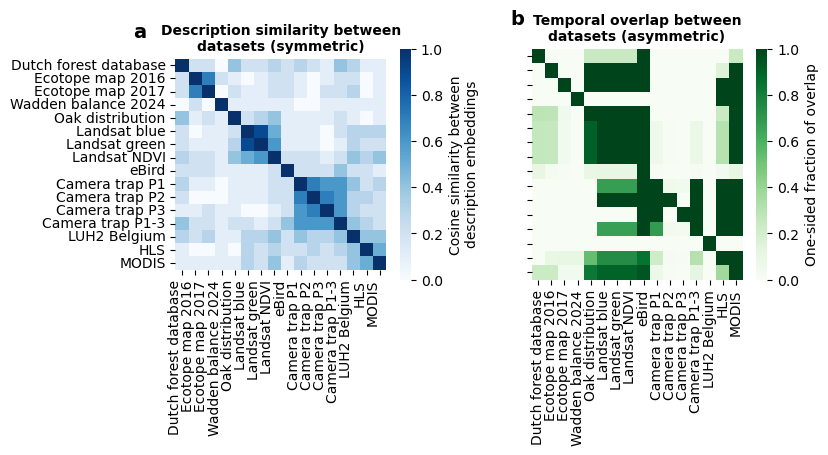

In [154]:
save_fig = True

fig, ax = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'wspace': 0.35})
plot_sim_embedding_matrix(loaded_data, remove_upper_triangle=False, save_fig=False, ax=ax[0], annot_hm=False)
plot_temp_overlap(df_conversion, save_fig=False, overlap_method='one-sided', ax=ax[1], annot_hm=False)
## assert yticklabels are the same
assert all([x.get_text() == y.get_text() for (x, y) in zip(ax[0].get_yticklabels(), ax[1].get_yticklabels())]), "Y-tick labels are not the same"
ax[1].set_yticklabels(['' for _ in ax[1].get_yticklabels()])  # Remove y-tick labels from the second plot
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title("Description similarity between\ndatasets (symmetric)", fontsize=10, fontweight='bold')
ax[1].set_title("Temporal overlap between\ndatasets (asymmetric)", fontsize=10, fontweight='bold')
ax[0].annotate(f"a", xy=(-0.2, 1.17), xycoords='axes fraction', fontsize=14, fontweight='bold',
                       ha='left', va='top')
ax[1].annotate(f"b", xy=(-0.1, 1.17), xycoords='axes fraction', fontsize=14, fontweight='bold',
                       ha='left', va='top')

if save_fig:
    fig.savefig("figs/description_similarity_and_temporal_overlap.pdf", bbox_inches='tight')

In [ ]:
from datetime import datetime

def split_temporal_coverage(temporal_coverages):
    temporal_coverage_list = temporal_coverages.split(",")
    ans = []
    
    for temporal_coverage in temporal_coverage_list:
        if isinstance(temporal_coverage, str):
            parts = temporal_coverage.split("-")
            if len(parts) == 6:
                start_time = datetime.strptime("-".join(parts[:3]), "%Y-%m-%d")
                end_time = datetime.strptime("-".join(parts[3:]), "%Y-%m-%d")
                
            elif len(parts) == 4:
                now = datetime.now()
                if parts[0].strip().lower() == "present":
                    start_time = now
                    end_time = datetime.strptime("-".join(parts[1:]), "%Y-%m-%d")
                elif parts[-1].strip().lower() == "present":
                    end_time = datetime.strptime("-".join(parts[:-1]), "%Y-%m-%d")
                    end_time = now
            ans.append((start_time, end_time))
    
    return ans

split_temporal_coverage(response_text)

[(datetime.datetime(2015, 11, 28, 0, 0), datetime.datetime(2025, 5, 31, 0, 0)),
 (datetime.datetime(2015, 11, 28, 0, 0),
  datetime.datetime(2025, 6, 7, 13, 37, 12, 146600)),
 (datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0)),
 (datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2022, 12, 31, 0, 0)),
 (datetime.datetime(2025, 6, 7, 13, 37, 12, 146626),
  datetime.datetime(2050, 12, 31, 0, 0)),
 (datetime.datetime(1982, 1, 1, 0, 0), datetime.datetime(2005, 12, 31, 0, 0)),
 (datetime.datetime(1800, 1, 1, 0, 0), datetime.datetime(2023, 12, 31, 0, 0)),
 (datetime.datetime(2021, 8, 13, 0, 0), datetime.datetime(2023, 8, 31, 0, 0)),
 (datetime.datetime(2021, 8, 14, 0, 0), datetime.datetime(2021, 9, 24, 0, 0)),
 (datetime.datetime(2023, 3, 1, 0, 0), datetime.datetime(2023, 3, 31, 0, 0)),
 (datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2023, 12, 31, 0, 0)),
 (datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2022, 12, 31, 0, 0)),
 (datetime.datetime(

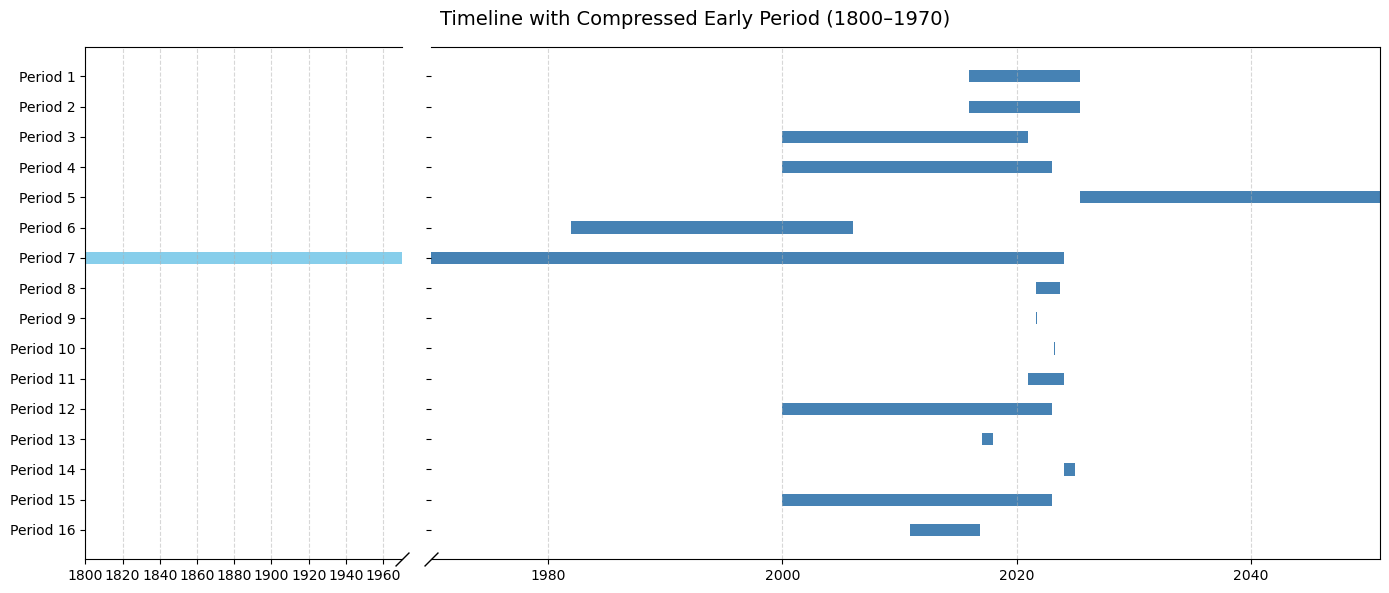

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Data
time_ranges = split_temporal_coverage(response_text)

# Create two side-by-side plots with a broken x-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 3]})

# Define break point
break_year = datetime(1970, 1, 1)

# Plot bars
for idx, (start, end) in enumerate(time_ranges):
    if end < break_year:
        ax1.barh(idx, (end - start).days, left=start, height=0.4, align='center', color='skyblue')
    elif start > break_year:
        ax2.barh(idx, (end - start).days, left=start, height=0.4, align='center', color='steelblue')
    else:
        # Spans both sides: split
        ax1.barh(idx, (break_year - start).days, left=start, height=0.4, align='center', color='skyblue')
        ax2.barh(idx, (end - break_year).days, left=break_year, height=0.4, align='center', color='steelblue')

# Set y-axis labels
ax1.set_yticks(range(len(time_ranges)))
ax1.set_yticklabels([f"Period {i+1}" for i in range(len(time_ranges))])
ax1.invert_yaxis()

# Format x-axis
for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(mdates.YearLocator(20))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

# Set x-limits
ax1.set_xlim(datetime(1800, 1, 1), datetime(1970, 1, 1))
ax2.set_xlim(datetime(1970, 1, 2), datetime(2050, 12, 31))

# Add break indicators
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.tick_params(labelright=False)
ax2.tick_params(labelleft=False)

# Add diagonal break marks
kwargs = dict(marker=[(-1, -1), (1, 1)], markersize=10,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [0], transform=ax2.transAxes, **kwargs)

# Labels
fig.suptitle("Timeline with Compressed Early Period (1800–1970)", fontsize=14)
plt.tight_layout()
plt.show()
